# My Own Neural Networks by Keras (- Keras VS PyTorch -)
### moriitkys

# <font color="OrangeRed">データセットのバックアップを取ってから実行してください</font>
## Make a backup of your dataset before running this program

KerasやPyTorchで学習をする際のパラメータ設定ＵＩとデータセット準備ができます。   
File Directory　クラスごとにフォルダを作り、その中に該当クラスの画像を全て入れる(<font color="OrangeRed">データがそれぞれ10以下の場合エラーが出る可能性あり</font>)   
MyOwnNN/dataset/1/img0001.png, img0002.png, ...   
MyOwnNN/dataset/2/img0001.png, img0002.png, ...   
- 1や2はクラス名で、HookWrenchやSpannerWrenchという名前でもOK   
- クラスのラベルとデータパスの対応を示したtxtやcsvのようなファイルは必要なく、データの入ったフォルダから自動でクラス名を取得してcategoriesに保持し対応付けます。
- 環境などはセルの最下部に記載
- UIの出現は時間かかります（10秒ほど)

In [2]:
#Settings and prepare your dataset
import glob
import os
import sys

import keras
from keras import layers, models, optimizers
from keras.utils import np_utils
import keras.backend as K
import keras.layers as KL
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.preprocessing.image import random_rotation, random_shift, random_zoom

import numpy as np
import random
import matplotlib.pyplot as plt

import PIL
from PIL import Image
import cv2

from pathlib import Path
import shutil

from sklearn.model_selection import train_test_split

import mylib.makedataset_rgb as mkdataset
import mylib.create_panel as create_panel
import mylib.utils as myutils

# ------ Setting panels ------
import tkinter
from tkinter import messagebox
img_size_mynet = [224,224]# You can change input image size(Pay attention to network shape)
setting_panel = create_panel.CreatePanel(img_size_mynet = img_size_mynet)
setting_panel.create_buttons()#If you push "start", exit this line.

# ------ set params and preparing dataset ------
flag_train = setting_panel.flag_train
flag_aug = setting_panel.flag_aug
flag_split = setting_panel.flag_split
ratio_train = float(setting_panel.var_sp.get())#0.0 ~ 1.0
total_epochs = int(setting_panel.var_sp_epochs.get())

type_backbone = setting_panel.type_backbone#ex) ResNet, Mobilenet, MyNet
layer_name_gradcam = setting_panel.layer_name_gradcam# Don't use 
img_size = setting_panel.img_size#ex) ResNet:[224,224], Mobilenet:[192,192], MyNet:[28,28]
print(type_backbone)
print("img_size=" + str(img_size))

#How many classes are in "dataset" folder
categories = [i for i in os.listdir(os.getcwd().replace("/mylib", "") + "/dataset")]
categories_idx = {}#ex) HookWrench:0, SpannerWrench:1
for i, name in enumerate(categories):
    categories_idx[name] = i
nb_classes = len(categories)#ex) nb_classes=2

dirname_dataset = "dataset"# dataset folder
dirname_dataset_val = dirname_dataset + "_val"
output_folder = "outputs_keras/"+type_backbone
x_train, y_train, x_val, y_val = [],[],[],[]

def aug_dataset(dirname_dataset_1, dirname_dataset_val_1):
    '''
    This function returns updated dataset dirname 
    Contain MakeDatasetRGB() (mylib/makedataset_rgb.py)
    Argument1: Foldername (String), Argument2: Foldername (String)
    Usage:
    dirname_dataset, dirname_dataset_val = aug_dataset(dirname_dataset, dirname_dataset_val)
    '''
    dirname_dataset_aug = dirname_dataset_1 + "_aug"
    dirname_dataset_val_aug = dirname_dataset_val_1 + "_aug"
    make_dataset = mkdataset.MakeDataSetRGB()
    if os.path.exists(dirname_dataset_aug ) == True \
    or os.path.exists(dirname_dataset_val_aug ) == True:
        #https://pythonbasics.org/tkinter-messagebox/
        tki2 = tkinter.Tk()
        tki2.withdraw()
        ret = messagebox.askyesno('確認', '_augフォルダがあります。_augフォルダ内を消去してよろしいですか？')
        if ret == True:
            if os.path.exists(dirname_dataset_aug ) == True:
                shutil.rmtree(dirname_dataset_aug)
            if os.path.exists(dirname_dataset_val_aug ) == True:
                shutil.rmtree(dirname_dataset_val_aug)
            make_dataset.do_augmentation(dataset_folder_name = "dataset")
            make_dataset.do_augmentation(dataset_folder_name = "dataset_val")
            tki2.destroy()
        else:
            tki2.destroy()
        tki2.mainloop()
    else:
        make_dataset.do_augmentation(dataset_folder_name = "dataset")
        make_dataset.do_augmentation(dataset_folder_name = "dataset_val")
        
    dirname_dataset_2 = dirname_dataset_1 + "_aug"
    dirname_dataset_val_2 = dirname_dataset_val_1 + "_aug"
    return dirname_dataset_2, dirname_dataset_val_2

def prepare_dataset_val():
    for j in categories:
        if os.path.exists(dirname_dataset_val  + "\\" + str(j) ) == False:
            os.makedirs(dirname_dataset_val + "\\" + str(j))
            files = glob.glob(dirname_dataset + "\\" + str(j) + "/*")
            for imgfile in files:# move some data from "dataset" to "dataset_val"
                if myutils.train_or_val(ratio_train) == "val":
                    shutil.move(imgfile, dirname_dataset_val+"\\" + str(j) + "/")

def revert_dataset_val():
    '''
    Revert Dataset ("dataset" & "dataset_val" -> "dataset")
    This function revert splitted validation dataset directory to dataset directory
    '''
    for j in categories:
        if os.path.exists(dirname_dataset_val  + "\\" + str(j) ) == True:
            files = glob.glob(dirname_dataset_val + "\\" + str(j) + "/*")
            for imgfile in files:#Move all images in "dataset_val" to "dataset"
                shutil.move(imgfile, dirname_dataset + "\\" + str(j))
    if os.path.exists(dirname_dataset_val) == True:
        shutil.rmtree(dirname_dataset_val)#Delete "dataset_val" folder

def prepare_dataset(dirname_dataset, dirname_dataset_val):
    label = 0
    for j in categories:# Prepare Training Dataset
        files = glob.glob(dirname_dataset + "\\" + str(j) + "/*")
        for imgfile in files:
            img = load_img(imgfile, target_size=(img_size[0], img_size[1]))
            array = img_to_array(img) / 255
            x_train.append(array)
            y_train.append(label)
        label += 1

    label = 0
    for j in categories:# Prepare Validation Dataset
        files = glob.glob(dirname_dataset_val + "\\" + str(j) + "/*")
        for imgfile in files:
            img = load_img(imgfile, target_size=(img_size[0], img_size[1]))
            array = img_to_array(img) / 255
            x_val.append(array)
            y_val.append(label)
        label += 1
            
if flag_train == True:
    print("train mode")
    print("total epochs = " + str(total_epochs))
    if flag_split == True:
        revert_dataset_val()
        prepare_dataset_val()
        print("splitting complete")
    if flag_split == False and os.path.exists(dirname_dataset_val) == False:
        prepare_dataset_val()
        print("You have not splitted dataset, so splitteing automatically done")
    if flag_aug == True:
        dirname_dataset, dirname_dataset_val = aug_dataset(dirname_dataset, dirname_dataset_val)
        print("dataset source is " + dirname_dataset + "&" + dirname_dataset_val)
    elif flag_aug == False:
        dirname_dataset_aug = dirname_dataset + "_aug"
        dirname_dataset_val_aug = dirname_dataset_val + "_aug"
        make_dataset = mkdataset.MakeDataSetRGB()
        if os.path.exists(dirname_dataset_aug ) == True \
        and os.path.exists(dirname_dataset_val_aug ) == True:
            dirname_dataset = dirname_dataset_aug
            dirname_dataset_val = dirname_dataset_val_aug
    prepare_dataset(dirname_dataset, dirname_dataset_val)
    # make directory (weights_folder, outputs)
    if os.path.exists("weights_pytorch/"+type_backbone) == False:
        os.makedirs("weights_pytorch/"+type_backbone)
    if os.path.exists("outputs_pytorch/"+type_backbone) == False:
        os.makedirs("outputs_pytorch/"+type_backbone)
        
if os.path.exists(output_folder) == False:
    os.makedirs(output_folder)

# In Keras, use numpy array for NN model
if os.path.exists("tmp_npy") == False:
    os.makedirs("tmp_npy")
x_train, y_train, x_val, y_val = np.array(x_train), np.array(y_train), np.array(x_val), np.array(y_val)
np.save("tmp_npy/x_train.npy", x_train)
np.save("tmp_npy/y_train.npy", y_train)
np.save("tmp_npy/x_test.npy", x_val)
np.save("tmp_npy/y_test.npy", y_val)
x_train, y_train, x_val, y_val = [],[],[],[]
print("Complete")

Using TensorFlow backend.


ResNet50
img_size=[224, 224]
Complete


In [2]:
# Build the selected model
from keras.applications.mobilenet import MobileNet
from keras.applications.resnet50 import ResNet50
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.core import Dense, Dropout, Flatten
from keras.models import Model, load_model, Sequential
from keras.optimizers import Adam, RMSprop, SGD

base_model = Sequential()
top_model = Sequential()

INPUT_SHAPE = (img_size[0], img_size[1], 3)
neuron_total = 500

if type_backbone == "ResNet50":
    INPUT_SHAPE = (img_size[0], img_size[1], 3)
    base_model = ResNet50(
        include_top = False,
        weights = "imagenet",
        input_shape = INPUT_SHAPE
    )
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(nb_classes, activation='softmax'))

elif type_backbone == "Mobilenet":
    INPUT_SHAPE = (img_size[0], img_size[1], 3)
    base_model = MobileNet(
        include_top = False,
        weights = "imagenet",
        input_shape = INPUT_SHAPE
    )
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(nb_classes, activation='softmax'))
    
elif type_backbone == "MyNet":
    INPUT_SHAPE = (img_size[0], img_size[1], 3)
    #base_model.add(Flatten(input_shape=INPUT_SHAPE))
    base_model.add(Dense(neuron_total, activation='relu',
                         input_shape=(INPUT_SHAPE[0]*INPUT_SHAPE[1]*INPUT_SHAPE[2],)))
    #base_model.add(Dense(neuron_total, activation='relu'))
    #base_model.add(Dense(neuron_total, activation='relu'))
    base_model.add(Dropout(0.5))
    top_model.add(Dense(nb_classes, activation='softmax', 
                  input_shape=base_model.output_shape[1:]))
    #top_model.add(Dense(nb_classes, activation='sigmoid'))

# Concatenate base_model(backbone) with top model
model = Model(input=base_model.input, output=top_model(base_model.output))

print("{}層".format(len(model.layers)))

# Train All layers
#for layer in model.layers[:-6]:
#    layer.trainable = False
#for layer in base_model.layers:
#    layer.trainable = False

# Compile the model
model.compile(
    optimizer = SGD(lr=0.001),
    loss = 'categorical_crossentropy',
    metrics = ["accuracy"]
)

model.summary()

176層
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activ

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`


In [3]:
# Start training or loading saved model
x_train = np.load("tmp_npy/x_train.npy")
y_train = np.load("tmp_npy/y_train.npy")
x_val = np.load("tmp_npy/x_test.npy")
y_val = np.load("tmp_npy/y_test.npy")
print("x_train length is " + str(len(x_train)))
#print(x_train.shape)

x_train1 = x_train
x_val1 = x_val
if type_backbone == "MyNet":
    x_train1 = x_train.reshape(len(x_train), INPUT_SHAPE[0]*INPUT_SHAPE[1]*INPUT_SHAPE[2])
    x_val1 = x_val.reshape(len(x_val), INPUT_SHAPE[0]*INPUT_SHAPE[1]*INPUT_SHAPE[2])
y_train1=np_utils.to_categorical(y_train,nb_classes)
y_val1=np_utils.to_categorical(y_val,nb_classes)

output_folder = "outputs_keras/"+type_backbone
if flag_train == True:
    if os.path.exists("weights_keras/"+type_backbone) == False:
        os.makedirs("weights_keras/"+type_backbone)
    checkpoint_path = "weights_keras/"+type_backbone+"/cp_{epoch:04d}.hdf5"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    cp_callback = keras.callbacks.ModelCheckpoint(
        filepath = checkpoint_path,
        verbose = 1,
        save_weights_only = True,
        period = 10)#Save the weights per 10 epochs
    
    model.save_weights(checkpoint_path.format(epoch=0))
    
    history = model.fit(
        x_train1,
        y_train1,
        epochs=total_epochs, 
        callbacks = [cp_callback],
        batch_size=32,
        validation_data=(x_val1,y_val1))

    score=model.evaluate(x_val1,y_val1,verbose=0)
    print("val loss : ",score[0])
    print("val acc : ",score[1])

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.savefig(output_folder+"/graph_loss.png")
    plt.show()
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.savefig(output_folder+"/graph_acc.png")
    plt.show()
elif flag_train == False:
    weights_folder_path = "weights_keras/"+type_backbone+"/"
    files = os.listdir(weights_folder_path)
    best_weights_path = max(files)# use the last weights
    best_weights_path = "weights_keras/"+type_backbone+"/" + best_weights_path 
    #print(best_weights_path)
    model.load_weights(best_weights_path)
    print("loaded weights: "+best_weights_path)

x_train length is 0
weights_keras/ResNet50/cp_0040.hdf5
loaded weights


['conv1', 'res2a_branch2a', 'res2a_branch2b', 'res2a_branch2c', 'res2a_branch1', 'res2b_branch2a', 'res2b_branch2b', 'res2b_branch2c', 'res2c_branch2a', 'res2c_branch2b', 'res2c_branch2c', 'res3a_branch2a', 'res3a_branch2b', 'res3a_branch2c', 'res3a_branch1', 'res3b_branch2a', 'res3b_branch2b', 'res3b_branch2c', 'res3c_branch2a', 'res3c_branch2b', 'res3c_branch2c', 'res3d_branch2a', 'res3d_branch2b', 'res3d_branch2c', 'res4a_branch2a', 'res4a_branch2b', 'res4a_branch2c', 'res4a_branch1', 'res4b_branch2a', 'res4b_branch2b', 'res4b_branch2c', 'res4c_branch2a', 'res4c_branch2b', 'res4c_branch2c', 'res4d_branch2a', 'res4d_branch2b', 'res4d_branch2c', 'res4e_branch2a', 'res4e_branch2b', 'res4e_branch2c', 'res4f_branch2a', 'res4f_branch2b', 'res4f_branch2c', 'res5a_branch2a', 'res5a_branch2b', 'res5a_branch2c', 'res5a_branch1', 'res5b_branch2a', 'res5b_branch2b', 'res5b_branch2c', 'res5c_branch2a', 'res5c_branch2b', 'res5c_branch2c']
0 0
The above image is predicted as HookWrench
0 0
The abo

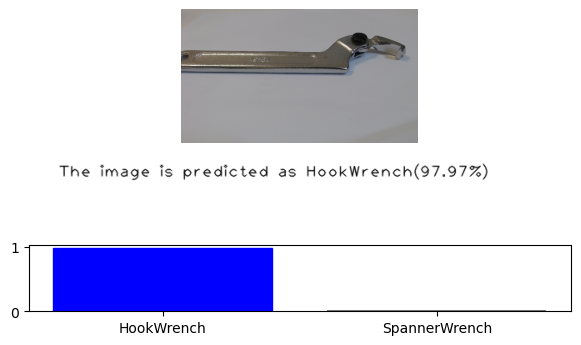

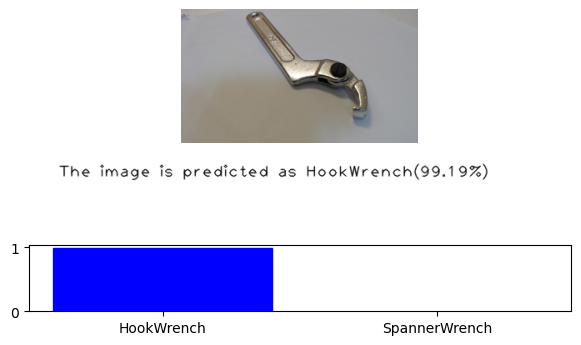

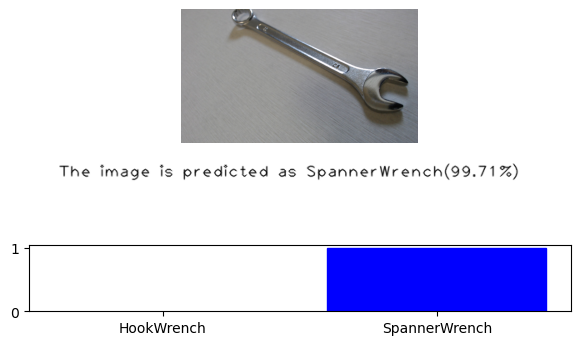

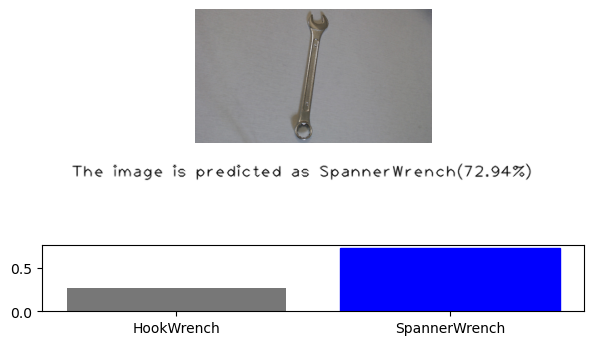

In [4]:
# Inference test images
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

k = 1

names_conv = [l.name for l in model.layers
                      if isinstance(l, keras.layers.Conv2D)]
print(names_conv)

for j in categories:
    files_test = glob.glob("test/"+str(j)+"/*")
    for i in files_test:
        img_test = load_img(i, target_size=(img_size[0], img_size[1]))
        true_label = categories_idx[j]
        array_test = img_to_array(img_test) / 255
        input_test = []
        input_test.append(array_test)
        input_tests = np.array(input_test)
        if type_backbone == "MyNet":
            input_tests = input_tests.reshape(len(input_tests), INPUT_SHAPE[0]*INPUT_SHAPE[1]*INPUT_SHAPE[2])
        probs_pred = model.predict(input_tests)# inference

        pred_classes = np.argmax(probs_pred, axis = 1)
        x = np.array(input_tests)

        predictions_array, true_label =  probs_pred[0], int(true_label)
        predicted_label = np.argmax(predictions_array)
        print(true_label, predicted_label)

        test_img = cv2.imread(i)

        blank_img = np.full((80, 600, 3), (255, 255, 255), dtype=np.uint8)

        text_show = "The image is predicted as "+str(categories[predicted_label]) +"("+str(round(float(max(predictions_array)*100), 2))+"%)"
        cv2.putText(blank_img, text_show, (10, 20), cv2.FONT_HERSHEY_PLAIN, 1.3, (0, 0, 0), 1, cv2.LINE_AA)
        test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)

        #img_v_concat = cv2.vconcat([np.asarray(blank_img),np.asarray(test_img)])

        fig = plt.figure(figsize = (7,4), dpi= 100)

        gs_master = GridSpec(nrows = 3, ncols = 1, height_ratios = (2,1,1))
        gs = [0]*3
        gs[0] = GridSpecFromSubplotSpec(nrows = 1, ncols = 1, subplot_spec = gs_master[0, 0:1])
        gs[1] = GridSpecFromSubplotSpec(nrows = 2, ncols = 1, subplot_spec = gs_master[1, 0])
        gs[2] = GridSpecFromSubplotSpec(nrows = 3, ncols = 1, subplot_spec = gs_master[2, 0])
        ax = [0]*3
        for m in range(len(gs)):
            ax[m] = fig.add_subplot(gs[m][:,:])

        #ax[0].imshow(np.asarray(img_v_concat))
        ax[0].imshow(np.asarray(test_img))
        ax[0].axis('off')

        ax[1].imshow(np.asarray(blank_img))
        ax[1].axis('off')

        thisplot = ax[2].bar(categories, predictions_array, color="#777777")
        thisplot[predicted_label].set_color('red')
        thisplot[true_label].set_color('blue')

        plt.savefig(output_folder+"/"+str(k) + 'figure.png')
        print("The above image is predicted as "+categories[predicted_label])
        #plt.show()

        k += 1

ResNetの実行ではMemory 16GBでVRAM 6GBはないときついです。実行時にメモリ使用量が10GB以上になっていました。

以下はdataset_valのデータをdatasetに統合するプログラムなので、必要な時以外に実行しないでください。   
Don't use the next cell except merging dataset_val and dataset

In [3]:
# Revert Dataset (dataset & dataset_val -> dataset)
import glob
import shutil
import os
#categories = [i for i in os.listdir(os.getcwd().replace("/mylib", "") + "/dataset")]
categories = [i for i in os.listdir(os.getcwd() + "/dataset")]

dirname_dataset = "dataset"# dataset folder
dirname_dataset_val = dirname_dataset + "_val" # validation dataset folder

def revert_dataset_val():
    '''
    Revert Dataset ("dataset" & "dataset_val" -> "dataset")
    This function revert splitted validation dataset directory to dataset directory
    '''
    for j in categories:
        if os.path.exists(dirname_dataset_val  + "\\" + str(j) ) == True:
            files = glob.glob(dirname_dataset_val + "\\" + str(j) + "/*")
            for imgfile in files:#Move all images in "dataset_val" to "dataset"
                shutil.move(imgfile, dirname_dataset + "\\" + str(j))
    if os.path.exists(dirname_dataset_val) == True:
        shutil.rmtree(dirname_dataset_val)#Delete "dataset_val" folder
revert_dataset_val()

### Environment 実行環境
- Windows10
- CPU:Core i7-7700HQ
- Memory: 16GB
- Graphic board: GTX1060 6GB
- Strage: NVMe M.2 SSD 1TB
- CUDA 9.0.176   
- cuDNN 7.0.5   


- Keras==2.1.5
- tensorflow-gpu==1.11.0
- torch==1.1.0
- scikit-learn==0.19.1
- scipy==1.4.1